<a href="https://colab.research.google.com/github/jrTanvirHasan27/Railway-Obstacle-Detections/blob/main/ResNet50_Rail_Obstacle_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [ ]:
!unzip "/content/drive/MyDrive/8th Semester/Research/Augmented Dataset.zip" -d "/content/Dataset/"

In [ ]:
!unzip "/content/drive/MyDrive/8th Semester/Research/Augmented- Test.zip" -d "/content/Dataset/"

In [4]:
train_path = '/content/Dataset/Augmented Dataset'
test_path = '/content/Dataset/Augmented- Test/Test'
val_path = '/content/Dataset/Augmented- Test/Validation'

Obstacle


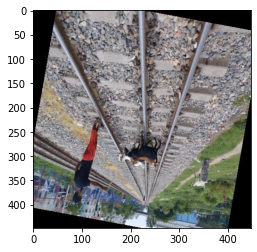

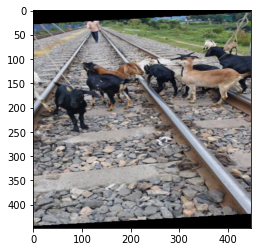

Empty Track


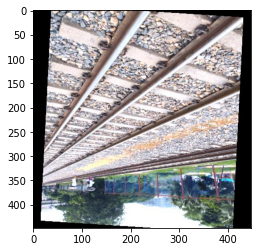

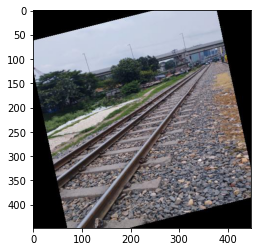

In [5]:
for folder in os.listdir(train_path):
  sub_path = train_path + "/" + folder

  print(folder)
  for i in range(2):
    temp_path = os.listdir(sub_path)[i]
    temp_path = sub_path + "/" + temp_path
    img = mpimg.imread(temp_path)
    implot = plt.imshow(img)
    plt.show()

In [6]:
def imagearray(path, size):
  data = []
  for folder in os.listdir(path):
    sub_path = path + "/" + folder

    for img in os.listdir(sub_path):
      image_path = sub_path + "/" + img
      img_arr = cv2.imread(image_path)
      img_arr = cv2.resize(img_arr, size)
      data.append(img_arr)
  
  return data

In [7]:
size = (320, 320)

In [8]:
%%time
train = imagearray(train_path, size)
test = imagearray(test_path, size)
val = imagearray(val_path, size)

CPU times: user 34.7 s, sys: 2.16 s, total: 36.9 s
Wall time: 28.4 s


In [9]:
x_train = np.array(train)
x_test = np.array(test)
x_val = np.array(val)

In [10]:
def data_class(data_path, size, class_mode):
  datagen = ImageDataGenerator()
  classes = datagen.flow_from_directory(data_path,
                                        target_size = size,
                                        batch_size = 32,
                                        class_mode = class_mode)
  return classes

In [11]:
train_class = data_class(train_path, size, "sparse")
test_class = data_class(test_path, size, "sparse")
val_class = data_class(val_path, size, "sparse")

Found 3192 images belonging to 2 classes.
Found 1980 images belonging to 2 classes.
Found 1050 images belonging to 2 classes.


In [12]:
y_train = train_class.classes
y_test = test_class.classes
y_val = val_class.classes

In [13]:
train_class.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [14]:
train_class.class_indices

{'Empty Track': 0, 'Obstacle': 1}

In [15]:
print("Y_Train Shape:", y_train.shape,
      "Y_Test Shape:", y_test.shape,
      "Y_Val Shape:", y_val.shape)

Y_Train Shape: (3192,) Y_Test Shape: (1980,) Y_Val Shape: (1050,)


In [16]:
vgg = ResNet50(input_shape = (320,320,3), weights = 'imagenet', include_top = False)

94781440/94765736 [==============================] - 1s 0us/step


In [17]:
for layer in vgg.layers:
  layer.trainable = False

In [18]:
x = Flatten()(vgg.output)
prediction = Dense(3, activation = "softmax")(x)

In [19]:
model = Model(vgg.input, prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

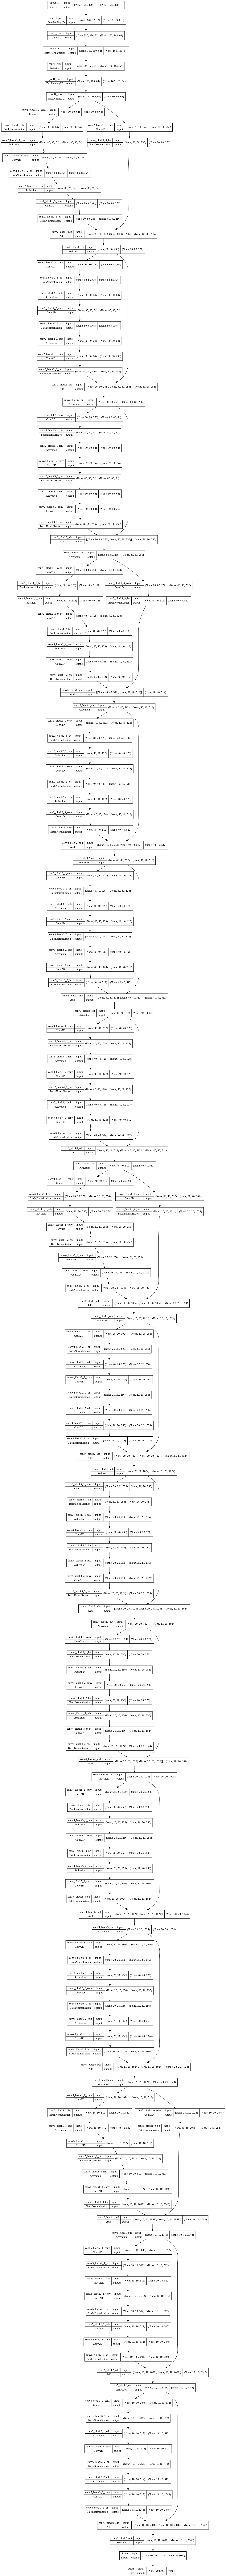

In [20]:
plot_model(model = model, show_shapes = True)

In [21]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = "min", verbose = 1, patience = 5)

In [22]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [23]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 20, callbacks = [early_stop], batch_size =30,
                    shuffle = True)

Epoch 1/20
107/107 [==============================] - 44s 281ms/step - loss: 0.5364 - accuracy: 0.9659 - val_loss: 7.1794 - val_accuracy: 0.9343
Epoch 2/20
107/107 [==============================] - 24s 222ms/step - loss: 0.0813 - accuracy: 0.9947 - val_loss: 10.9545 - val_accuracy: 0.9419
Epoch 3/20
107/107 [==============================] - 24s 227ms/step - loss: 0.0451 - accuracy: 0.9969 - val_loss: 10.5413 - val_accuracy: 0.9419
Epoch 4/20
107/107 [==============================] - 24s 228ms/step - loss: 0.0923 - accuracy: 0.9966 - val_loss: 12.8879 - val_accuracy: 0.9429
Epoch 5/20
107/107 [==============================] - 24s 224ms/step - loss: 0.1174 - accuracy: 0.9956 - val_loss: 17.2548 - val_accuracy: 0.9410
Epoch 6/20
107/107 [==============================] - 24s 224ms/step - loss: 0.0395 - accuracy: 0.9981 - val_loss: 15.4033 - val_accuracy: 0.9419
Epoch 6: early stopping


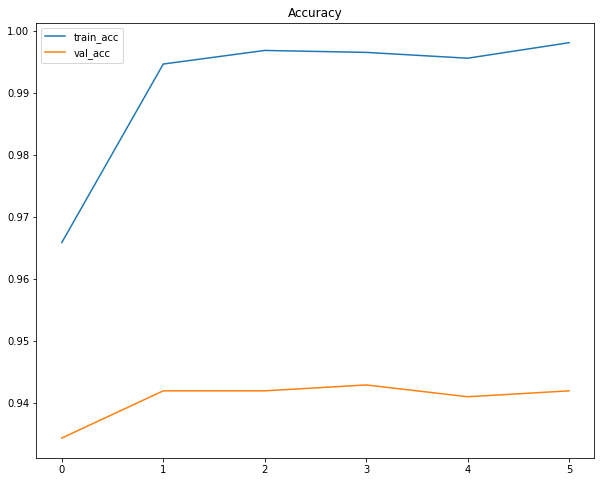

In [24]:
plt.figure(figsize = (10,8))
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

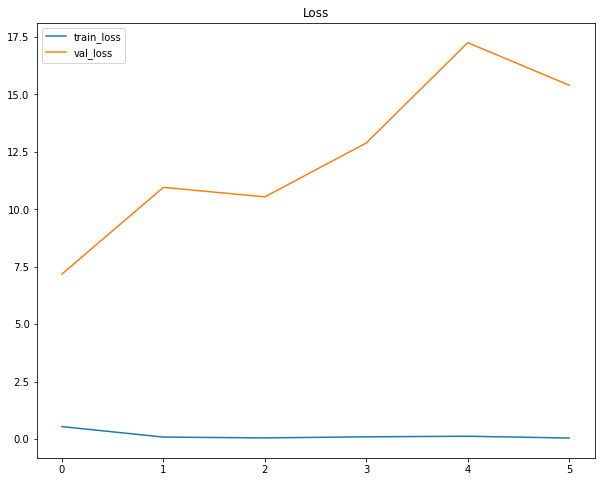

In [25]:
plt.figure(figsize = (10,8))
plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.title("Loss")
plt.show()

In [26]:
model.evaluate(x_test, y_test, batch_size =32)

62/62 [==============================] - 15s 203ms/step - loss: 21.2315 - accuracy: 0.9020


[21.231542587280273, 0.9020202159881592]

In [27]:
y_pred = model.predict(x_test)

In [28]:
y_pred = np.argmax(y_pred, axis = 1)

In [29]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       961
           1       0.91      0.89      0.90      1019

    accuracy                           0.90      1980
   macro avg       0.90      0.90      0.90      1980
weighted avg       0.90      0.90      0.90      1980



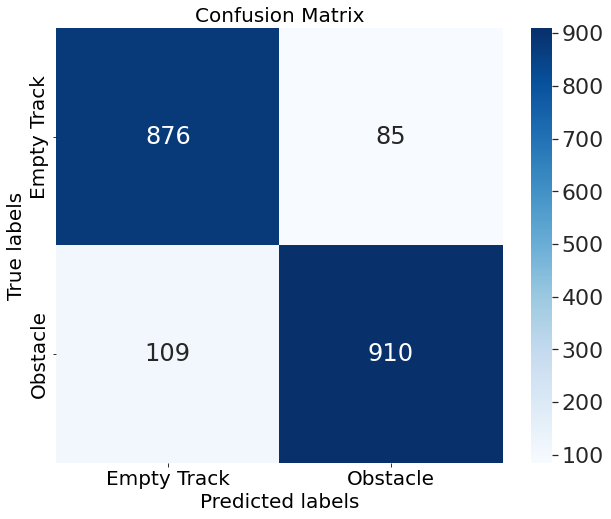

In [30]:
cm = confusion_matrix(y_pred,y_test)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20);ax.set_ylabel('True labels', fontsize=20); 
ax.set_title('Confusion Matrix', fontsize=20); 
ax.xaxis.set_ticklabels(['Empty Track', 'Obstacle'], fontsize=20); ax.yaxis.set_ticklabels(['Empty Track', 'Obstacle'], fontsize=20);

In [31]:
f1_score(y_test, y_pred, average='micro')

0.902020202020202

In [32]:
recall_score(y_test, y_pred, average='weighted')

0.902020202020202

In [33]:
precision_score(y_test, y_pred, average='micro')

0.902020202020202